# H3K27ac extra

* Percentiles based analysis
* Wiggle and noise mixtures
* Jaccard MACS2 broad vs SPAN investigation

In [148]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os

In [149]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

# Load hg38 peaks


In [150]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K27ac']
GSE26320_REPS = ['rep1', 'rep2']

! mkdir -p {GSE26320_PATH_HG38}/pics

In [151]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [155]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), '.scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN']
df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 17


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 17


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 17


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 17


,file,modification,cell,replicate,fdr,peaks,avlength,tool
11,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,K562,rep2,0.1,26701,1805.836560,MACS2 broad
1,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27ac,HepG2,rep2,0.01,27516,3266.488007,SICER
14,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,NHEK,rep2,0.05,43724,1687.588098,SPAN
5,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,NHLF,rep2,0.1,41503,1689.789774,MACS2 broad
10,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27ac,HSMM,rep2,0.01,41796,2852.579290,SICER


In [156]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

# Update peaks to contain only percentile only

In [157]:
# df_fdr_peaks.drop(['avlength'], axis=1, inplace=True)
df_fdr_peaks['original_file'] = df_fdr_peaks['file']

step = 20
for percentage in [0, 20, 40, 60, 80]:
    percentage_name = f'{percentage}%-{percentage + step}%'
    ! mkdir -p {GSE26320_PATH_HG38}/percentiles/{percentage_name}
    print(percentage_name)
    percentile_files = []
    for file, cell, replicate in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['cell'], df_fdr_peaks['replicate'])):
        union_path = f'{GSE26320_PATH_HG38}/union/H3K27ac_{cell}_{replicate}.bed'
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
    
        pf = f'{GSE26320_PATH_HG38}/percentiles/{percentage_name}_H3K27ac_{cell}_{replicate}.bed'
        # Take % peaks by lengths and compute ratios inside
        t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
            pf, sep='\t', index=False, header=None
        )
        # Prepare percentage
        file_perc = f'{GSE26320_PATH_HG38}/percentiles/{percentage_name}/{os.path.basename(file)}' 
        print(percentage_name, cell, replicate, file_perc)
        ! bedtools intersect -wa -u -a {sorted_file(file)} -b {sorted_file(pf)} > {file_perc}
        percentile_files.append(file_perc)
    df_fdr_peaks[percentage_name] = percentile_files

df_fdr_peaks.sample(5)

0%-20%


0it [00:00, ?it/s]

0%-20% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% HSMM rep1

0it [00:00, ?it/s]

20%-40% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
20%-40% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
20%-40% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
20%-40% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak


0it [00:00, ?it/s]

40%-60% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
40%-60% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
40%-60% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
40%-60% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak


0it [00:00, ?it/s]

60%-80% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
60%-80% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
60%-80% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
60%-80% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak


0it [00:00, ?it/s]

80%-100% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
80%-100% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
80%-100% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
80%-100% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646414_Huvec_H3K27ac_rep1_q0.05_p

,file,modification,cell,replicate,fdr,peaks,avlength,tool,original_file,0%-20%,20%-40%,40%-60%,60%-80%,80%-100%
8,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,HMEC,rep1,0.1,29088,1385.748934,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
15,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,GM12878,rep1,0.05,34842,2249.681964,SPAN,/home/jetbrains/data/2023_GSE26320/span/GSM646...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
3,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,K562,rep1,0.1,39486,1439.443347,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
1,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,HSMM,rep1,0.05,38858,1544.996088,SPAN,/home/jetbrains/data/2023_GSE26320/span/GSM646...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
6,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,H1,rep1,0.1,15680,1062.139732,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...


# Coverage for the given percentile settings

In [173]:
# Compute coverage on given percentile settings
# df_fdr_peaks['file'] = df_fdr_peaks['0%-20%']
# df_fdr_peaks['file'] = df_fdr_peaks['40%-60%']
df_fdr_peaks['file'] = df_fdr_peaks['80%-100%']

In [174]:
# Fraction of reads in peaks
GSE26320_PATH_HG38_BW = GSE26320_PATH_HG38 + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if cell and rep and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell, rep)
    return df_bws

In [175]:
bws_df = load_bws(GSE26320_PATH_HG38_BW, 'H3K27ac')
display(bws_df.sample(3))
bws_control_df = load_bws(GSE26320_PATH_HG38_BW, 'Input')
display(bws_control_df.sample(3))

  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
8,/home/jetbrains/data/2023_GSE26320/bw/GSM64633...,H3K27ac,H1,rep1
2,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,H3K27ac,HepG2,rep1
16,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,H3K27ac,GM12878,rep1


  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
5,/home/jetbrains/data/2023_GSE26320/bw/GSM64645...,Input,K562,rep2
11,/home/jetbrains/data/2023_GSE26320/bw/GSM64637...,Input,HepG2,rep1
9,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,Input,HMEC,rep2


In [176]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH_HG38, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}

## FRIP

In [177]:
import pyBigWig
import tempfile
from itertools import product

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'replicate', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    # for c, r in tqdm(product(['GM12878'], ['rep1'])):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K27ac') &
                   (bws_df['cell'] == c) & (bws_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]))
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(
                bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        frip_df.loc[len(frip_df)] = (c, r, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)

frip_df

0it [00:00, ?it/s]

GM12878 rep1
MACS2 broad /tmp/tmprqahzhxc /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
SICER /tmp/tmprraolm51 /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
SPAN /tmp/tmpe3hmtssj /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
MACS2 /tmp/tmpz82qrkmg /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
GM12878 rep2
MACS2 broad /tmp/tmp4k6bgrlx /home/jetbrains/data/2023_GSE26320/bw/GSM646317_GM12878_H3K27ac_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646333_GM12878_Input_rep2.bw
SICER /tmp/tmpwen4vyau /home/jetbrains/data/2023_GSE26320/bw/GSM646317_GM12878_H3K27ac_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM64

,cell,replicate,bw_file,tool,peaks_file,peaks,length,reads_in_peaks,all_reads,control_reads_in_peaks,control_all_reads
0,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,MACS2 broad,/tmp/tmprqahzhxc,9876,37160619,3.341714e+07,9.601462e+07,1.872251e+06,9.856627e+07
1,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,SICER,/tmp/tmprraolm51,6852,59606548,3.652669e+07,9.599063e+07,3.078541e+06,9.856627e+07
2,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,SPAN,/tmp/tmpe3hmtssj,9371,43509707,3.474764e+07,9.601462e+07,2.326831e+06,9.856627e+07
3,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,MACS2,/tmp/tmpz82qrkmg,22421,25203861,3.004449e+07,9.601462e+07,1.228969e+06,9.856627e+07
4,GM12878,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,MACS2 broad,/tmp/tmp4k6bgrlx,8985,33108223,3.251897e+07,9.689406e+07,1.806492e+06,9.837757e+07
...,...,...,...,...,...,...,...,...,...,...,...
63,HepG2,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,MACS2,/tmp/tmp2yrglwy8,21306,21881553,2.434796e+07,7.922325e+07,1.154439e+06,8.086781e+07
64,HepG2,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,MACS2 broad,/tmp/tmp7f1nfuge,6860,15149703,2.661855e+07,8.126260e+07,3.541297e+05,8.412824e+07
65,HepG2,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,SICER,/tmp/tmpzgpqikoo,5576,41936624,3.314373e+07,8.126260e+07,1.456920e+06,8.412824e+07
66,HepG2,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,SPAN,/tmp/tmpmyy6jgbj,7071,29478482,3.156573e+07,8.126260e+07,1.014165e+06,8.412824e+07


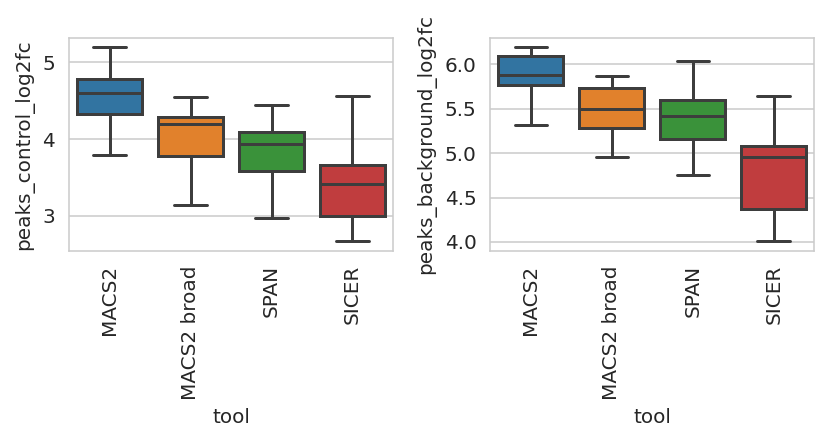

In [178]:
frip_df['peaks_background_log2fc'] = [
    np.log2((x / (z + 1e-10)) / ((y - x) / (sum(CHROM_SIZES.values()) - z + 1e-10)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / ((y + 1e-10) / 1e6), z / ((u + 1e-10) / 1e6) + 1e-10))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

import seaborn as sns

t = frip_df

plt.figure(figsize=(6, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
ax = axs[0]
g_results = sns.boxplot(data=t, x='tool', y='peaks_control_log2fc',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)

ax = axs[1]
g_results = sns.boxplot(data=t, x='tool', y='peaks_background_log2fc',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()

plt.show()

# Prepare datasets with wiggling and mixing control data into signal track

## Wiggle bed files, optionally 80-100%

In [252]:
WD = os.path.expanduser('~/data/2023_GSE26320_wiggle_mix')

percentile_file = f'{WD}/80%-100%_H3K27ac_GM12878_rep1.bed'
bed = f'{WD}/GSM646316_GM12878_H3K27ac_rep1.bed'
tf1 = tempfile.mktemp()
tf2 = tempfile.mktemp()
! bedtools intersect -a {sorted_file(bed)} -b {sorted_file(percentile_file)} -wa > {tf1}
! bedtools intersect -a {sorted_file(bed)} -b {sorted_file(percentile_file)} -wa -v > {tf2}
tf1_len, tf2_len = lines(tf1), lines(tf2)
print('Overlapping', tf1_len, 'Non-onverlapping', tf2_len)

Overlapping 2725496 Non-onverlapping 4323562


In [253]:
t = pd.read_csv(tf1, sep='\t', header=None)
t.sample(5)

,0,1,2,3,4,5
578564,chr12,54358806,54358857,SRR094196.26010281,42,-
2380443,chr7,87152130,87152181,SRR094196.19874961,42,+
1823202,chr3,141403378,141403429,SRR094196.12460683,42,+
266101,chr10,7472910,7472961,SRR094196.26815357,42,+
245849,chr1,230109412,230109463,SRR094196.2526855,42,-


In [254]:
# Wiggle signal in 80-100% area  (first version was 30% / 30%)
# We keep some reads intact to recover fragment size
signal = t.sample(int(len(t) * 0.5))
noise = t.sample(int(len(t) * 0.5))
delta = [int(x) for x in np.random.normal(0, 5_000, size=len(noise))]
noise[1] += delta
noise[2] += delta
# Ensure generated reads have proper coordinates
noise.loc[noise[1] < 1, 1] = 1
noise.loc[noise[2] < 1, 2] = 1

In [255]:
t = pd.concat([signal, noise]).reset_index(drop=True)
t.to_csv(tf1, sep='\t', index=False, header=None)

In [256]:
result_file = f'{WD}/GSM646316_GM12878_H3K27ac_rep1_wiggle_80_100.bed'
! cat {tf1} > {result_file}
! cat {tf2} >> {result_file}

In [257]:
del t, signal, noise, delta

## Wiggle all coverage

In [353]:
t = pd.read_csv(bed, sep='\t', header=None)
print('Reads', len(t))
t.sample(5)

Reads 7049058


,0,1,2,3,4,5
4171345,chr5,151211347,151211398,SRR094196.14765725,42,-
101059,chr18,54357455,54357506,SRR094196.22881995,42,-
6697466,chr2,85463692,85463743,SRR094196.22745476,42,-
4274230,chr13,28013530,28013581,SRR094196.8226799,40,+
803566,chr4,3105801,3105852,SRR094196.19699475,42,-


In [354]:
signal = t.sample(int(len(t) * 0.8))
noise = t.sample(int(len(t) * 0.2))
delta = [int(x) for x in np.random.normal(0, 5_000, size=len(noise))]
noise[1] += delta
noise[2] += delta
# Ensure generated reads have proper coordinates
noise.loc[noise[1] < 1, 1] = 1
noise.loc[noise[2] < 1, 2] = 1

signal.to_csv(tf1, sep='\t', index=False, header=None)
noise.to_csv(tf2, sep='\t', index=False, header=None)

In [355]:
result_file = f'{WD}/GSM646316_GM12878_H3K27ac_rep1_wiggle.bed'
! cat {tf1} > {result_file}
! cat {tf2} >> {result_file}

In [356]:
del t, signal, noise, delta

## Mixing with input

In [262]:
signal = pd.read_csv(bed, sep='\t', header=None)
reads = len(signal)
print('Reads', reads)
signal.sample(5)

Reads 7049058


,0,1,2,3,4,5
4297914,chr13,36315265,36315316,SRR094196.26067952,42,-
6009951,chr6,122863565,122863616,SRR094196.23796692,42,+
4623115,chr12,62592512,62592563,SRR094196.26363061,42,-
545765,chr7,39501365,39501416,SRR094196.22530206,42,-
3193836,chr3,15345293,15345344,SRR094196.9256336,42,-


In [263]:
input = f'{WD}/GSM646332_GM12878_Input_rep1.bed'
noise = pd.read_csv(input, sep='\t', header=None)
noise.sample(5)

,0,1,2,3,4,5
1346644,chr14,69390271,69390322,SRR094215.6700580,39,+
2491681,chr10,124558736,124558787,SRR094215.2434434,42,+
2454867,chr10,107677341,107677392,SRR094215.7741014,42,+
2068113,chr9,125537713,125537764,SRR094215.7353324,39,+
527983,chr7,85518568,85518619,SRR094215.2062731,42,+


In [264]:
signal = signal.sample(int(reads * 0.5))
noise = noise.sample(int(reads * 0.5))
signal.to_csv(tf1, sep='\t', index=False, header=None)
noise.to_csv(tf2, sep='\t', index=False, header=None)
result_file = f'{WD}/GSM646316_GM12878_H3K27ac_rep1_mix.bed'
! cat {tf1} > {result_file}
! cat {tf2} >> {result_file}

In [265]:
del signal, noise

# Lengths distribution in noise conditions

Please rerun snakemake smk-chipseq-pipeline for mix and wiggle tracks.

In [357]:
k27ac_peaks = df_fdr_peaks[(df_fdr_peaks['modification'] == 'H3K27ac') & 
                           (df_fdr_peaks['cell'] == 'GM12878') &
                           (df_fdr_peaks['replicate'] == 'rep1')].copy()
k27ac_peaks['file'] = k27ac_peaks['original_file']
k27ac_peaks['name'] = k27ac_peaks['tool']
k27ac_peaks['type'] = 'base'
k27ac_peaks

,file,modification,cell,replicate,fdr,peaks,avlength,tool,original_file,0%-20%,20%-40%,40%-60%,60%-80%,80%-100%,name,type
9,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep1,0.05,47290,885.814401,MACS2,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,MACS2,base
15,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep1,0.1,31476,2079.336892,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,MACS2 broad,base
9,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27ac,GM12878,rep1,0.01,32861,3777.138219,SICER,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,SICER,base
15,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,GM12878,rep1,0.05,34842,2249.681964,SPAN,/home/jetbrains/data/2023_GSE26320/span/GSM646...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,SPAN,base


In [358]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(WD, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(WD, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(WD, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), '.scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(WD, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks_mix_wiggle = pd.concat([k27ac_peaks, df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks_mix_wiggle['name'] = df_fdr_peaks_mix_wiggle['tool'] 
df_fdr_peaks_mix_wiggle['type'] = 'base'

mix_rows = ['mix' in os.path.basename(f) for f in df_fdr_peaks_mix_wiggle['file']]
wiggle_rows = ['wiggle' in os.path.basename(f) and not '80_100' in os.path.basename(f) 
               for f in df_fdr_peaks_mix_wiggle['file']]
wiggle_80_100_rows = ['wiggle_80_100' in os.path.basename(f) for f in df_fdr_peaks_mix_wiggle['file']]
df_fdr_peaks_mix_wiggle.loc[mix_rows, 'name'] = df_fdr_peaks_mix_wiggle[mix_rows]['name'] + ' mix'
df_fdr_peaks_mix_wiggle.loc[mix_rows, 'type'] = 'mix'
df_fdr_peaks_mix_wiggle.loc[wiggle_rows, 'name'] = df_fdr_peaks_mix_wiggle[wiggle_rows]['name'] + ' wiggle'
df_fdr_peaks_mix_wiggle.loc[wiggle_rows, 'type'] = 'wiggle'
df_fdr_peaks_mix_wiggle.loc[wiggle_80_100_rows, 'name'] = df_fdr_peaks_mix_wiggle[wiggle_80_100_rows]['name'] + ' wiggle 80-100%'
df_fdr_peaks_mix_wiggle.loc[wiggle_80_100_rows, 'type'] = 'wiggle 80-100%'
df_fdr_peaks_mix_wiggle

  0%|          | 0/24 [00:00<?, ?it/s]

MACS2 3


  0%|          | 0/24 [00:00<?, ?it/s]

MACS2 broad 3


  0%|          | 0/3 [00:00<?, ?it/s]

SICER 3


  0%|          | 0/6 [00:00<?, ?it/s]

SPAN 3


,file,modification,cell,replicate,fdr,peaks,avlength,tool,original_file,0%-20%,20%-40%,40%-60%,60%-80%,80%-100%,name,type
9,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep1,0.05,47290,885.814401,MACS2,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,MACS2,base
15,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep1,0.1,31476,2079.336892,MACS2 broad,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,MACS2 broad,base
9,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27ac,GM12878,rep1,0.01,32861,3777.138219,SICER,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,SICER,base
15,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,GM12878,rep1,0.05,34842,2249.681964,SPAN,/home/jetbrains/data/2023_GSE26320/span/GSM646...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,SPAN,base
0,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.05,30029,682.750441,MACS2,NaN,NaN,NaN,NaN,NaN,NaN,MACS2 mix,mix
1,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.05,53102,911.983466,MACS2,NaN,NaN,NaN,NaN,NaN,NaN,MACS2 wiggle 80-100%,wiggle 80-100%
2,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.05,44482,989.941977,MACS2,NaN,NaN,NaN,NaN,NaN,NaN,MACS2 wiggle,wiggle
0,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.1,28154,956.618491,MACS2 broad,NaN,NaN,NaN,NaN,NaN,NaN,MACS2 broad mix,mix
1,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.1,39095,1366.855404,MACS2 broad,NaN,NaN,NaN,NaN,NaN,NaN,MACS2 broad wiggle,wiggle
2,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.1,47618,1281.123714,MACS2 broad,NaN,NaN,NaN,NaN,NaN,NaN,MACS2 broad wiggle 80-100%,wiggle 80-100%


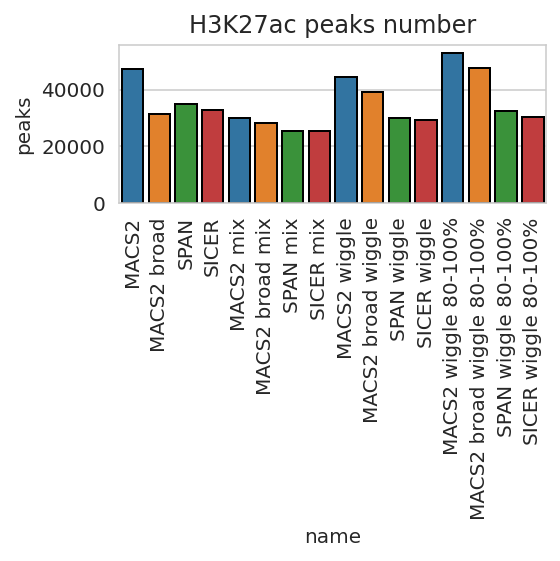

In [359]:
order = [f'{tool}{suffix}' for (suffix, tool) in product(['', ' mix', ' wiggle', ' wiggle 80-100%'], 
                                                         ['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])]
palette = {f'{tool}{suffix}': TOOLS_PALETTE[tool] 
           for (suffix, tool) in product(['', ' mix', ' wiggle', ' wiggle 80-100%'], 
                                         ['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])}

plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks_mix_wiggle, x='name', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=palette,
                        order=order)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K27ac peaks number')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_peaks_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

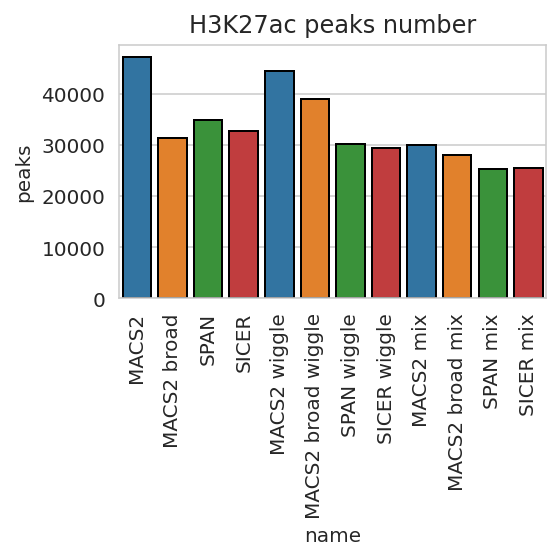

In [394]:
order = [f'{tool}{suffix}' for (suffix, tool) in product(['', ' wiggle', ' mix'],
                                                         ['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])]
palette = {f'{tool}{suffix}': TOOLS_PALETTE[tool]
           for (suffix, tool) in product(['', ' wiggle', ' mix'],
                                         ['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])}

plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks_mix_wiggle, x='name', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=palette,
                        order=order)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K27ac peaks number')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

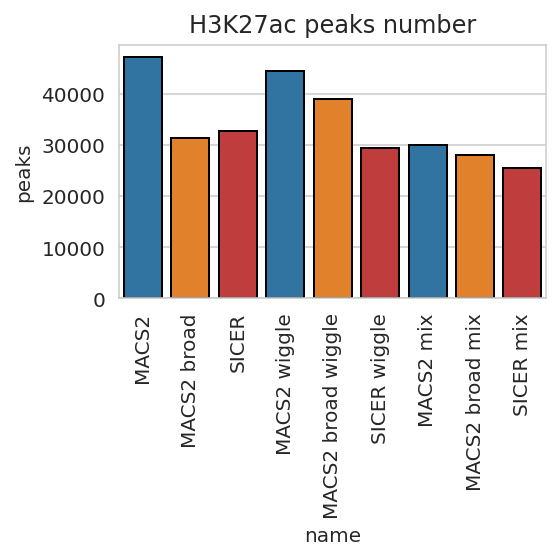

In [395]:
order = [f'{tool}{suffix}' for (suffix, tool) in product(['', ' wiggle', ' mix'],
                                                         ['MACS2', 'MACS2 broad', 'SICER'])]
palette = {f'{tool}{suffix}': TOOLS_PALETTE[tool]
           for (suffix, tool) in product(['', ' wiggle', ' mix'],
                                         ['MACS2', 'MACS2 broad', 'SICER'])}

plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks_mix_wiggle, x='name', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=palette,
                        order=order)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K27ac peaks number')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_peaks_nospan.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference between broad and narrow peaks

In [362]:
! mkdir -p {WD}/union

perc_len_dfs = []
perc_peaks_df = pd.DataFrame(columns=['type', 'length', 'tool', 'peaks'], dtype=object)

for ty in tqdm(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()

    print(ty)
    t = df_fdr_peaks_mix_wiggle[(df_fdr_peaks_mix_wiggle['modification'] == 'H3K27ac') &
                     (df_fdr_peaks_mix_wiggle['type'] == ty)]
    if len(t) == 0:
        continue
    try:
        t_span = sorted_file(t[t['tool'] == 'SPAN']['file'].values[0])
        t_macs2 = sorted_file(t[t['tool'] == 'MACS2']['file'].values[0])
        t_macs2broad = sorted_file(t[t['tool'] == 'MACS2 broad']['file'].values[0])
        t_sicer = sorted_file(t[t['tool'] == 'SICER']['file'].values[0])
        # Prepare total overlap
        union_path = f'{WD}/union/H3K27ac_{ty}.bed'
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            for tool, file in [('MACS2', t_macs2), ('MACS2 broad', t_macs2broad), ('SPAN', t_span), ('SICER', t_sicer)]:
                # Prepare tool percentage peaks
                ! bedtools intersect -wa -u -a {file} -b {sorted_file(tf)} > {file}-perc
                # print(tool)
                # ! wc -l {file}-perc
                peak_lengths = bedl(f'{file}-perc')
                tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
                tl['name'] = tool
                tl['type'] = ty
                tl['length'] = percentage_name
                perc_peaks_df.loc[len(perc_peaks_df)] = (ty, percentage_name, tool, len(peak_lengths))
                perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

    except Exception as e:
        print(e)

display(perc_peaks_df.sample(3))
perc_len_df = pd.concat(perc_len_dfs).reset_index(drop=True)
del perc_len_dfs
display(perc_len_df.sample(3))

  0%|          | 0/3 [00:00<?, ?it/s]

base
wiggle
mix


,type,length,tool,peaks
5,base,20%-40%,MACS2 broad,5073
46,mix,20%-40%,SPAN,4506
43,mix,0%-20%,SICER,4531


,peak_lengths,name,type,length
33571,782,SPAN,base,20%-40%
156542,255,MACS2 broad,wiggle,20%-40%
325908,3799,SICER,mix,60%-80%


base
wiggle
mix


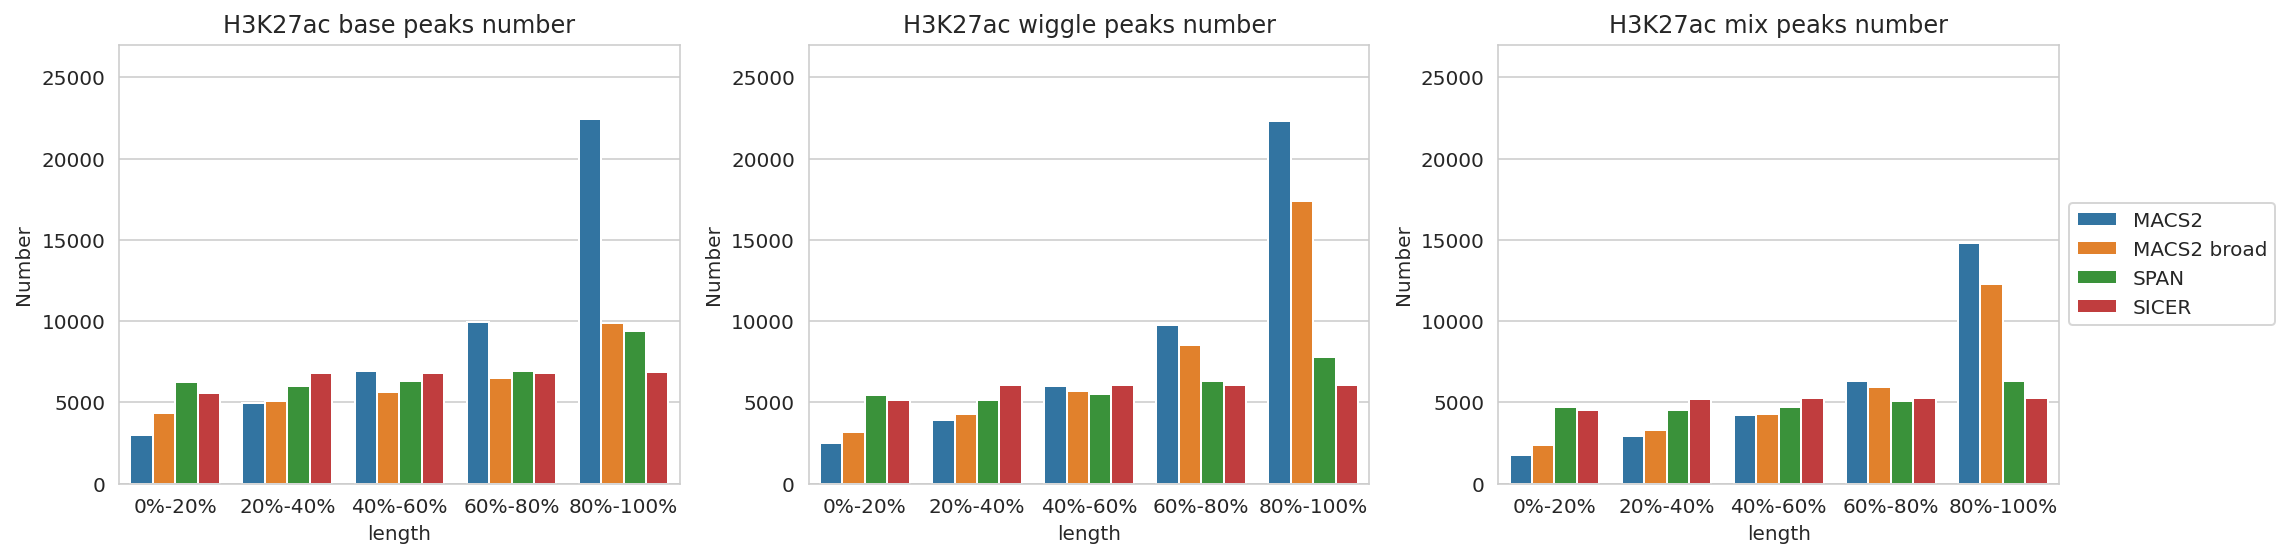

In [363]:
plt.figure(figsize=(16, 4))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]


for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()

    print(ty)
    ax = axs[i]
    g_results = sns.barplot(data=perc_peaks_df[perc_peaks_df['type'] == ty],
                            y='peaks', x='length', ax=ax,
                            hue='tool',
                            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(f'H3K27ac {ty} peaks number')
    g_results.axes.set_ylabel('Number')
    ax.set_ylim(0, 27_000)
    if i != 2:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_percentiles.pdf', bbox_inches='tight', dpi=300)
plt.show()

base
wiggle
mix


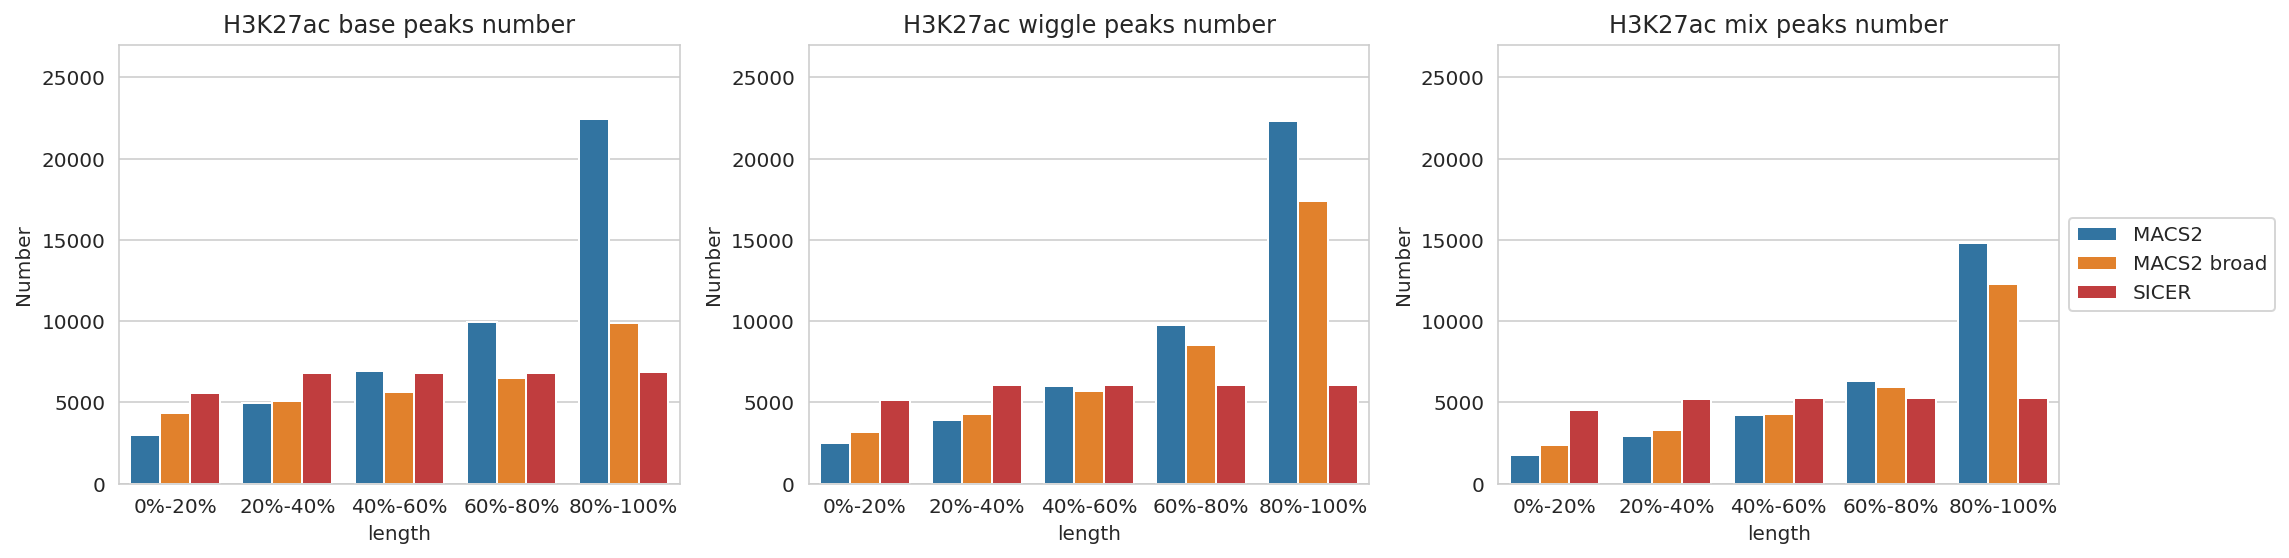

In [364]:
plt.figure(figsize=(16, 4))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]


for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()

    print(ty)
    ax = axs[i]
    g_results = sns.barplot(data=perc_peaks_df[perc_peaks_df['type'] == ty],
                            y='peaks', x='length', ax=ax,
                            hue='tool',
                            hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                            palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(f'H3K27ac {ty} peaks number')
    g_results.axes.set_ylabel('Number')
    ax.set_ylim(0, 27_000)
    if i != 2:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_percentiles_no_span.pdf', bbox_inches='tight', dpi=300)
plt.show()

base
wiggle
mix


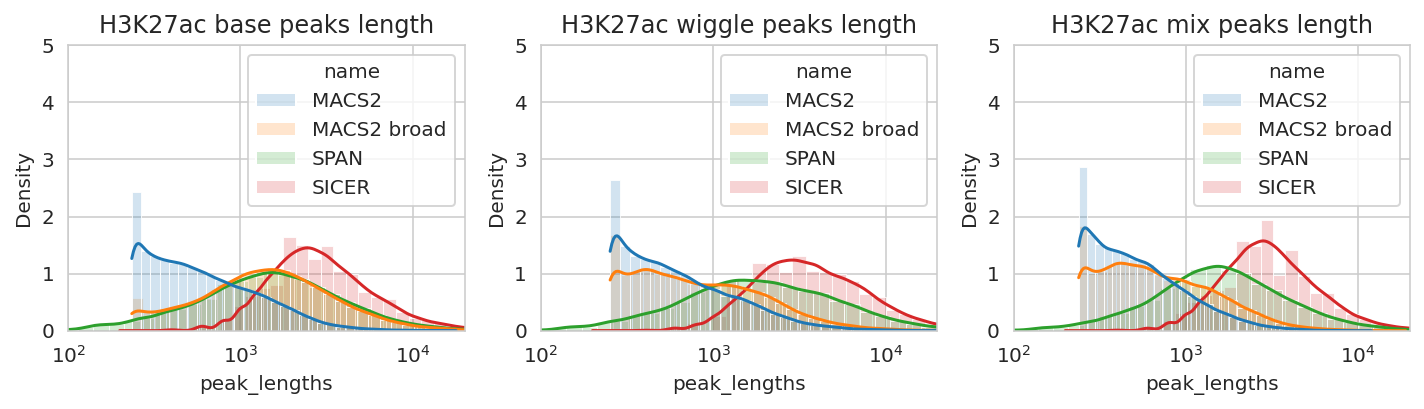

In [365]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]

for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()
    print(ty)
    ax = axs[i]
    g_results = sns.histplot(data=perc_len_df[perc_len_df['type'] == ty], x='peak_lengths', hue='name', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=35, kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=TOOLS)
    g_results.set(xscale='log')
    g_results.set_ylim(0, 5)
    g_results.set_xlim(1e2, 2e4)
    ax.title.set_text(f'H3K27ac {ty} peaks length')

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

base
wiggle
mix


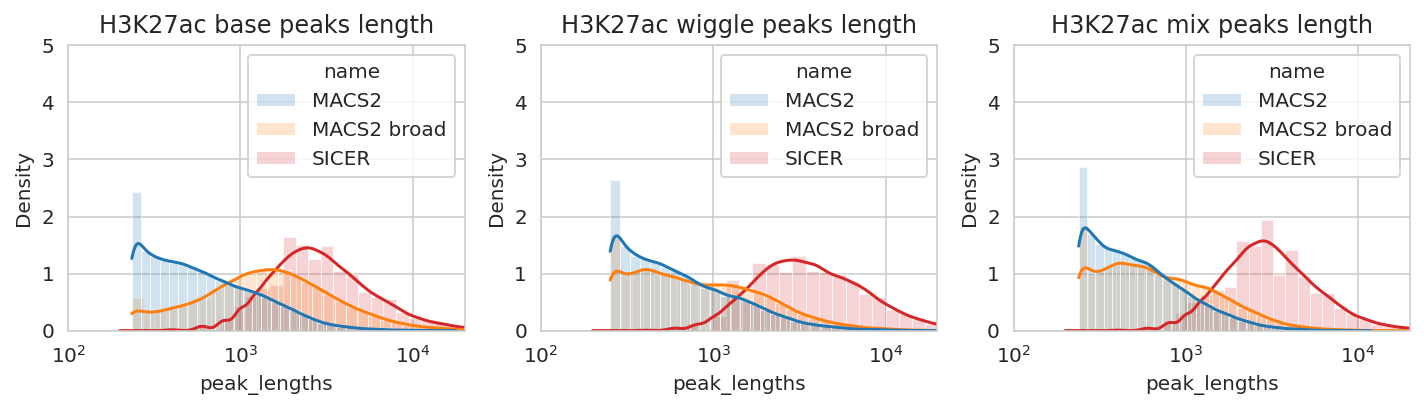

In [366]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]

for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()
    print(ty)
    ax = axs[i]
    g_results = sns.histplot(data=perc_len_df[perc_len_df['type'] == ty], x='peak_lengths', hue='name', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=35, kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=['MACS2', 'MACS2 broad', 'SICER'])
    g_results.set(xscale='log')
    g_results.set_ylim(0, 5)
    g_results.set_xlim(1e2, 2e4)
    ax.title.set_text(f'H3K27ac {ty} peaks length')

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths_nospan.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Estimate Coverage variance in mix / wiggle regions

In [376]:
from math import ceil
import pyBigWig

RD = os.path.expanduser('~/data/2023_Immune')
# bed_encode = os.path.expanduser('~/data/2023_GSE26320/percentiles/80%-100%_H3K27ac_GM12878_rep1.bed')
# bed_roadmap = f'{RD}/percentiles/80%-100%_H3K27ac_TCell.bed'
# bed_encode = os.path.expanduser('~/data/2023_GSE26320/span/GSM646316_GM12878_H3K27ac_rep1_100_0.05_3.peak')
# bed_roadmap = os.path.expanduser('~/data/2023_Immune/span/TCell_H3K27ac_hg38_ENCFF530DQB_100_0.05_3.peak')
bed_encode = os.path.expanduser('~/data/2023_GSE26320/union/H3K27ac_GM12878_rep1.bed')
bed_roadmap = os.path.expanduser('~/data/2023_Immune/union/H3K27ac_TCell.bed')
data = [
    ('wiggle', f'{WD}/bw/GSM646316_GM12878_H3K27ac_rep1_wiggle.bw', bed_encode),
    ('mix', f'{WD}/bw/GSM646316_GM12878_H3K27ac_rep1_mix.bw', bed_encode),
    ('ENCODE', f'{os.path.expanduser("~/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw")}', bed_encode),
    ('Roadmap', f'{RD}/bw/TCell_H3K27ac_hg38_ENCFF530DQB.bw', bed_roadmap)
]

variances = []
bin = 100
for name, bwf, percf in data:
    print(name, bwf, percf)
    t = pd.read_csv(percf, sep='\t', header=None)
    with pyBigWig.open(bwf) as bw:
        # Resort top scored peaks by density and start with the most dense ones
        total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
        print('Total coverage', total_coverage)
        for chr, start, end in tqdm(zip(t[0], t[1], t[2])):
            if chr in CHROM_SIZES:
                # Normalize by total coverage
                stats = [c / total_coverage for c in bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True)]
                variances.append((name, f'{chr}:{start}-{end}', np.var(stats))) 
            
df_vars = pd.DataFrame(variances, columns=['name', 'position', 'variance'])
del variances
df_vars.sample(5)

wiggle /home/jetbrains/data/2023_GSE26320_wiggle_80_100/bw/GSM646316_GM12878_H3K27ac_rep1_wiggle.bw /home/jetbrains/data/2023_GSE26320/union/H3K27ac_GM12878_rep1.bed
Total coverage 97.09043241160965


0it [00:00, ?it/s]

mix /home/jetbrains/data/2023_GSE26320_wiggle_80_100/bw/GSM646316_GM12878_H3K27ac_rep1_mix.bw /home/jetbrains/data/2023_GSE26320/union/H3K27ac_GM12878_rep1.bed
Total coverage 98.46390471062374


0it [00:00, ?it/s]

ENCODE /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/union/H3K27ac_GM12878_rep1.bed
Total coverage 95.99449994272328


0it [00:00, ?it/s]

Roadmap /home/jetbrains/data/2023_Immune/bw/TCell_H3K27ac_hg38_ENCFF530DQB.bw /home/jetbrains/data/2023_Immune/union/H3K27ac_TCell.bed
Total coverage 84.9097751298113


0it [00:00, ?it/s]

,name,position,variance
5139,wiggle,chr11:32136200-32138399,0.000001
61460,mix,chr6:38262000-38265199,0.000001
24120,wiggle,chr4:83034000-83036599,0.000020
60962,mix,chr6:12362000-12365599,0.000003
25917,wiggle,chr5:131256000-131259999,0.000024


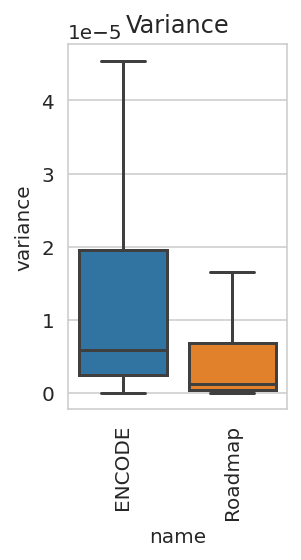

In [392]:
plt.figure(figsize=(2.2, 4))
ax = plt.axes()
g_results = sns.boxplot(data=df_vars[(df_vars['name'] == 'ENCODE') | (df_vars['name'] == 'Roadmap')], x='name', y='variance', showfliers=False)
ax.xaxis.set_tick_params(rotation=90)
# ax.title.set_text('Variance in 80%-100%')
ax.title.set_text('Variance')
plt.tight_layout()
plt.show()

In [382]:
from scipy.stats import mannwhitneyu
from scipy import stats

encode_vars = df_vars[df_vars['name'] == 'ENCODE']['variance'].values
roadmap_vars = df_vars[df_vars['name'] == 'Roadmap']['variance'].values

print('ENCODE Roamdap MannwhitneyU', mannwhitneyu(encode_vars, roadmap_vars))
print('ENCODE Roamdap Ttest', stats.ttest_ind(encode_vars, roadmap_vars))

ENCODE Roamdap MannwhitneyU MannwhitneyuResult(statistic=747737663.0, pvalue=0.0)
ENCODE Roamdap Ttest Ttest_indResult(statistic=39.037867901240595, pvalue=0.0)


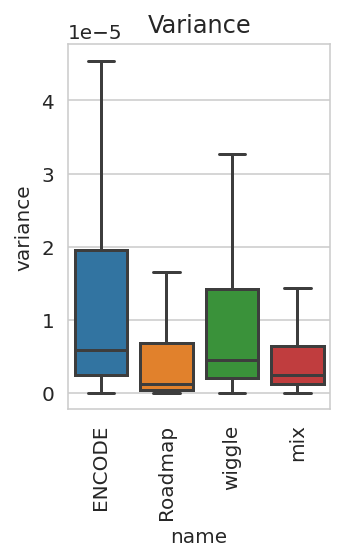

In [393]:
plt.figure(figsize=(2.5, 4))
ax = plt.axes()
g_results = sns.boxplot(data=df_vars, x='name', y='variance', showfliers=False,
                        order=['ENCODE', 'Roadmap', 'wiggle', 'mix'])
ax.xaxis.set_tick_params(rotation=90)
# ax.title.set_text('Variance in 80%-100%')
ax.title.set_text('Variance')
plt.tight_layout()
plt.show()

In [380]:
from scipy.stats import mannwhitneyu
from scipy import stats

wiggle_vars = df_vars[df_vars['name'] == 'wiggle']['variance'].values
mix_vars = df_vars[df_vars['name'] == 'mix']['variance'].values

print('Roadmap wiggle MannwhitneyU', mannwhitneyu(roadmap_vars, wiggle_vars))
print('Roadmap wiggle Ttest', stats.ttest_ind(roadmap_vars, wiggle_vars))

print('Roadmap wiggle MannwhitneyU', mannwhitneyu(roadmap_vars, mix_vars))
print('Roadmap wiggle Ttest', stats.ttest_ind(roadmap_vars, mix_vars))

Roadmap wiggle MannwhitneyU MannwhitneyuResult(statistic=305703815.0, pvalue=0.0)
Roadmap wiggle Ttest Ttest_indResult(statistic=-21.746790935403883, pvalue=1.7707520539140245e-104)
Roadmap wiggle MannwhitneyU MannwhitneyuResult(statistic=389968876.0, pvalue=0.0)
Roadmap wiggle Ttest Ttest_indResult(statistic=24.710059888475275, pvalue=3.551291901595129e-134)


# Compare Jaccard between MACS2 broad and SPAN

## GM12878

In [84]:
reps = {
    'MACS2 broad': [f'{GSE26320_PATH_HG38}/macs2/GSM646316_GM12878_H3K27ac_rep1_broad0.1_peaks.broadPeak',
                    f'{GSE26320_PATH_HG38}/macs2/GSM646317_GM12878_H3K27ac_rep2_broad0.1_peaks.broadPeak'],
    'SPAN': [f'{GSE26320_PATH_HG38}/span/GSM646316_GM12878_H3K27ac_rep1_100_0.05_3.peak',
             f'{GSE26320_PATH_HG38}/span/GSM646317_GM12878_H3K27ac_rep2_100_0.05_3.peak']
}
print('SPAN r1', lines(reps['SPAN'][0]), bedl(reps['SPAN'][0]).sum())
print('SPAN r2', lines(reps['SPAN'][1]), bedl(reps['SPAN'][1]).sum())

SPAN r1 34842 78383419
SPAN r2 31050 70478499


In [85]:
import tempfile

perc_reps_overlap = pd.DataFrame(
    columns=['tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

dfso = []
dfsl = []
for tool, (rep1, rep2) in reps.items():
    tf = tempfile.mktemp()
    # This prints only overlapping A and B features, skipping non-overlapping
    !bedtools intersect -a {sorted_file(rep1)} -b {sorted_file(rep2)} -wo > {tf}
    t = pd.read_csv(tf, sep='\t', header=None)
    tl = pd.DataFrame(dict(diff=pd.concat([t[10] - t[1], t[11] - t[2]]).reset_index(drop=True), 
                           overlap=pd.concat([t[18], t[18]]).reset_index(drop=True)))
    tl['name'] = tool
    dfsl.append(tl)
    
tl = pd.concat(dfsl).reset_index(drop=True)
display(tl.sample(3))

,diff,overlap,name
6981,73,732,MACS2 broad
424,-618,440,MACS2 broad
72758,170,5697,SPAN


In [86]:
tl['abs_diff'] = np.fabs(tl['diff']) + 1
tl = tl[(tl['overlap'] < 10_000) & (tl['abs_diff'] < 10_000)]

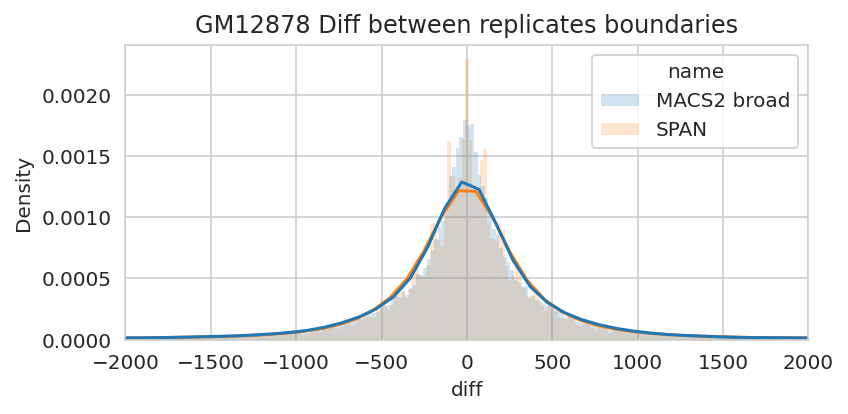

In [87]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, alpha=0.2)
g_results.set_xlim(-2_000, 2_000)
g_results.axes.title.set_text(f'GM12878 Diff between replicates boundaries')

plt.tight_layout()
plt.show()

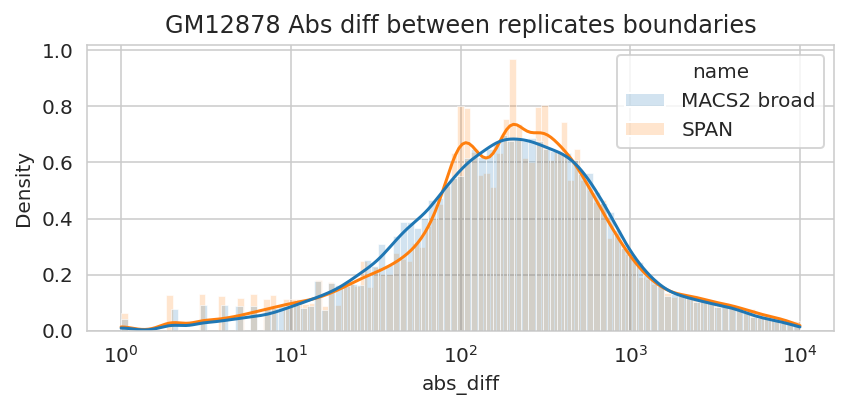

In [88]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='abs_diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.axes.title.set_text(f'GM12878 Abs diff between replicates boundaries')

plt.tight_layout()
plt.show()

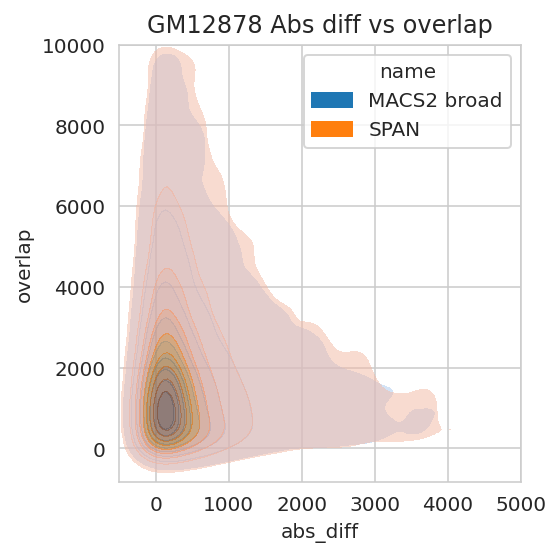

In [89]:
plt.figure(figsize=(4, 4))
g_results = sns.kdeplot(data=tl, x='abs_diff', y='overlap', hue='name', fill=True, alpha=0.5)
g_results.set_xlim(xmax=5_000)
g_results.set_ylim(ymax=10_000)
g_results.axes.title.set_text(f'GM12878 Abs diff vs overlap')
plt.tight_layout()
plt.show()

## HSMM

In [91]:
reps = {
    'MACS2 broad': [f'{GSE26320_PATH_HG38}/macs2/GSM646394_HSMM_H3K27ac_rep1_broad0.1_peaks.broadPeak',
                    f'{GSE26320_PATH_HG38}/macs2/GSM646395_HSMM_H3K27ac_rep2_broad0.1_peaks.broadPeak'],
    'SPAN': [f'{GSE26320_PATH_HG38}/span/GSM646394_HSMM_H3K27ac_rep1_100_0.05_3.peak',
             f'{GSE26320_PATH_HG38}/span/GSM646395_HSMM_H3K27ac_rep2_100_0.05_3.peak']
}
print('SPAN r1', lines(reps['SPAN'][0]), bedl(reps['SPAN'][0]).sum())
print('SPAN r2', lines(reps['SPAN'][1]), bedl(reps['SPAN'][1]).sum())

HSMM cell line
SPAN r1 38858 60035458
SPAN r2 49653 75247739


In [92]:
import tempfile

perc_reps_overlap = pd.DataFrame(
    columns=['tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

dfso = []
dfsl = []
for tool, (rep1, rep2) in reps.items():
    tf = tempfile.mktemp()
    # This prints only overlapping A and B features, skipping non-overlapping
    !bedtools intersect -a {sorted_file(rep1)} -b {sorted_file(rep2)} -wo > {tf}
    t = pd.read_csv(tf, sep='\t', header=None)
    tl = pd.DataFrame(dict(diff=pd.concat([t[10] - t[1], t[11] - t[2]]).reset_index(drop=True),
                           overlap=pd.concat([t[18], t[18]]).reset_index(drop=True)))
    tl['name'] = tool
    dfsl.append(tl)

tl = pd.concat(dfsl).reset_index(drop=True)
display(tl.sample(3))

,diff,overlap,name
55709,-279,1348,MACS2 broad
67557,-430,934,MACS2 broad
90163,79,1154,SPAN


In [93]:
tl['abs_diff'] = np.fabs(tl['diff']) + 1
tl = tl[(tl['overlap'] < 10_000) & (tl['abs_diff'] < 10_000)]

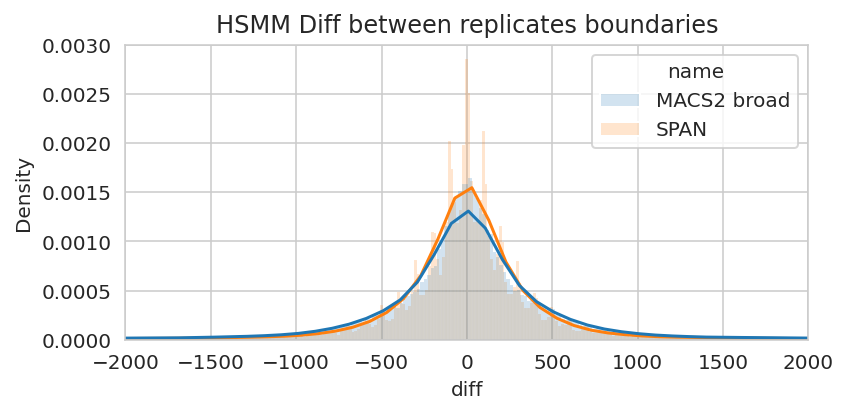

In [94]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, alpha=0.2)
g_results.set_xlim(-2_000, 2_000)
g_results.axes.title.set_text(f'HSMM Diff between replicates boundaries')

plt.tight_layout()
plt.show()

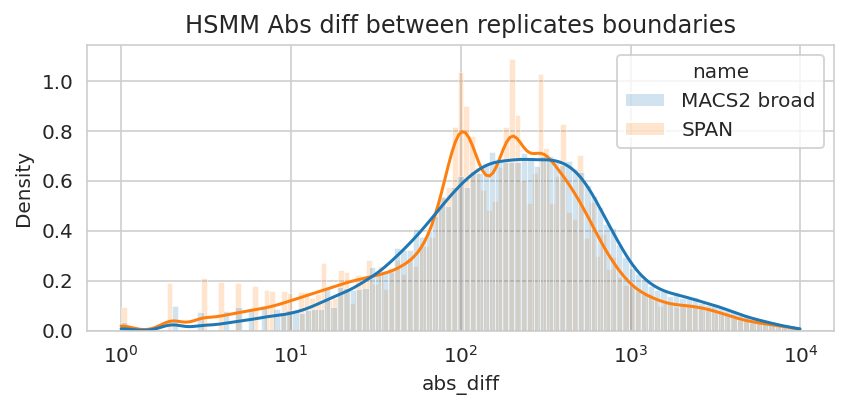

In [95]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='abs_diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.axes.title.set_text(f'HSMM Abs diff between replicates boundaries')

plt.tight_layout()
plt.show()

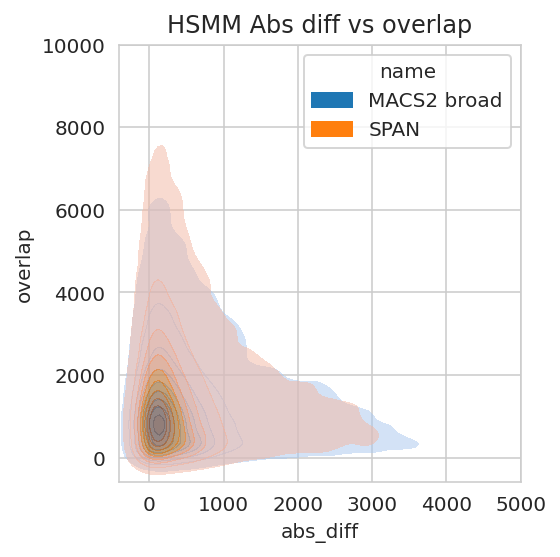

In [96]:
plt.figure(figsize=(4, 4))
g_results = sns.kdeplot(data=tl, x='abs_diff', y='overlap', hue='name', fill=True, alpha=0.5)
g_results.set_xlim(xmax=5_000)
g_results.set_ylim(ymax=10_000)
g_results.axes.title.set_text(f'HSMM Abs diff vs overlap')
plt.tight_layout()
plt.show()

## HMEC

In [99]:
reps = {
    'MACS2 broad': [f'{GSE26320_PATH_HG38}/macs2/GSM646374_HMEC_H3K27ac_rep1_broad0.1_peaks.broadPeak',
                    f'{GSE26320_PATH_HG38}/macs2/GSM646375_HMEC_H3K27ac_rep2_broad0.1_peaks.broadPeak'],
    'SPAN': [f'{GSE26320_PATH_HG38}/span/GSM646374_HMEC_H3K27ac_rep1_100_0.05_3.peak',
             f'{GSE26320_PATH_HG38}/span/GSM646375_HMEC_H3K27ac_rep2_100_0.05_3.peak']
}
print('SPAN r1', lines(reps['SPAN'][0]), bedl(reps['SPAN'][0]).sum())
print('SPAN r2', lines(reps['SPAN'][1]), bedl(reps['SPAN'][1]).sum())

SPAN r1 47858 82240423
SPAN r2 30534 51621487


In [100]:
import tempfile

perc_reps_overlap = pd.DataFrame(
    columns=['tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

dfso = []
dfsl = []
for tool, (rep1, rep2) in reps.items():
    tf = tempfile.mktemp()
    # This prints only overlapping A and B features, skipping non-overlapping
    !bedtools intersect -a {sorted_file(rep1)} -b {sorted_file(rep2)} -wo > {tf}
    t = pd.read_csv(tf, sep='\t', header=None)
    tl = pd.DataFrame(dict(diff=pd.concat([t[10] - t[1], t[11] - t[2]]).reset_index(drop=True),
                           overlap=pd.concat([t[18], t[18]]).reset_index(drop=True)))
    tl['name'] = tool
    dfsl.append(tl)

tl = pd.concat(dfsl).reset_index(drop=True)
display(tl.sample(3))

,diff,overlap,name
52787,945,462,MACS2 broad
17830,-905,1307,MACS2 broad
50783,378,630,MACS2 broad


In [101]:
tl['abs_diff'] = np.fabs(tl['diff']) + 1
tl = tl[(tl['overlap'] < 10_000) & (tl['abs_diff'] < 10_000)]

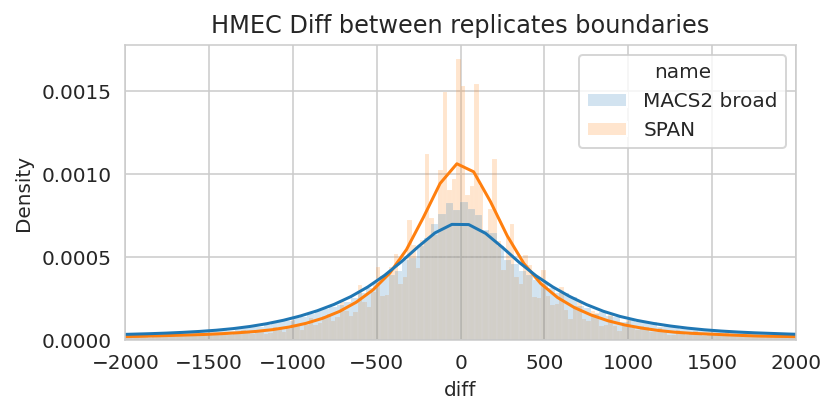

In [103]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, alpha=0.2)
g_results.set_xlim(-2_000, 2_000)
g_results.axes.title.set_text(f'HMEC Diff between replicates boundaries')

plt.tight_layout()
plt.show()

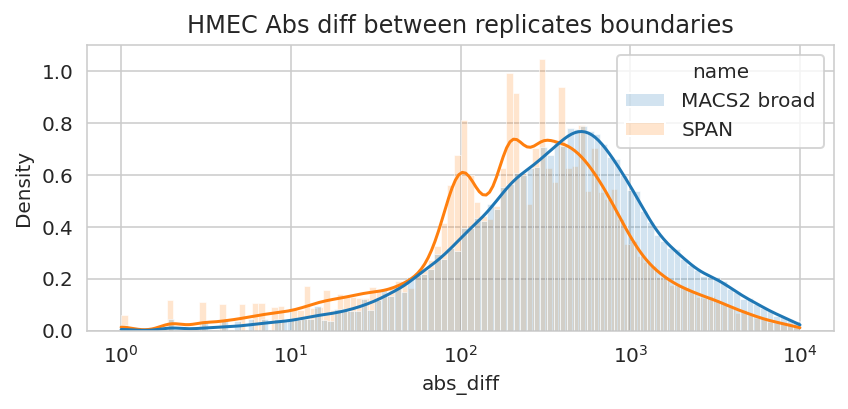

In [104]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='abs_diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.axes.title.set_text(f'HMEC Abs diff between replicates boundaries')

plt.tight_layout()
plt.show()

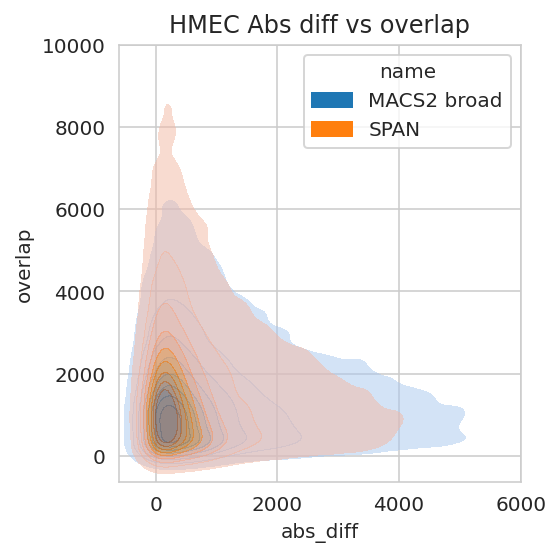

In [106]:
plt.figure(figsize=(4, 4))
g_results = sns.kdeplot(data=tl, x='abs_diff', y='overlap', hue='name', fill=True, alpha=0.5)
g_results.set_xlim(xmax=6_000)
g_results.set_ylim(ymax=10_000)
g_results.axes.title.set_text(f'HMEC Abs diff vs overlap')
plt.tight_layout()
plt.show()

# END